# Model Experimentation: Hyperparameter Optimization

## Imports and Setup

In [1]:
import os
import random

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sys
sys.path.insert(0, '../utils')
import model_utils
import geoutils

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

SEED = 42

%load_ext autoreload
%autoreload 2

## File Location

In [2]:
version = '20200509'
data_dir = "../data/"
output_dir = "../outputs/"
results_dir = output_dir + '10k_results/'

input_file = data_dir + '{}_dataset.csv'.format(version)
images_dir = data_dir + 'images/'
indices_dir = data_dir + 'indices/'
pos_mask_dir = data_dir + 'pos_masks/'
neg_mask_dir = data_dir + 'neg_masks/'

## Load Dataset

In [3]:
data = pd.read_csv(input_file).reset_index(drop=True)
print('Data dimensions: {}'.format(data.shape))
data.head(3)

Data dimensions: (1029869, 69)


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.15100,0.13225,0.14240,0.16430,0.1899,0.25700,0.2960,0.25510,0.32295,0.0396,...,-0.438625,0.151655,0.209614,0.479385,-0.665204,-0.060444,0.948025,3,39,0
1,0.15100,0.12885,0.13790,0.16185,0.1899,0.25700,0.2960,0.25755,0.32295,0.0396,...,-0.435450,0.151655,0.213526,0.488330,-0.663010,-0.059064,0.952352,3,39,0
2,0.15895,0.13730,0.15185,0.18915,0.2264,0.28555,0.3268,0.28085,0.35740,0.0416,...,-0.447333,0.145385,0.222971,0.473118,-0.661291,-0.060496,0.911748,3,39,0


## Resample Dataset

In [4]:
data = model_utils.resample(data, num_neg_samples=10000, random_state=SEED)
print('Data dimensions: {}'.format(data.shape))
data.head(3)

Data dimensions: (113756, 69)


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.1748,0.12640,0.12590,0.12075,0.1288,0.2291,0.28325,0.2551,0.31165,0.03960,...,-0.325365,0.336843,0.097095,0.493299,-0.683798,-0.120547,1.149291,2,62,0
1,0.2093,0.19810,0.20230,0.21700,0.2178,0.2767,0.32240,0.3020,0.34780,0.03530,...,-0.212563,0.098564,0.242471,0.716410,-0.623340,-0.022285,1.042249,2,64,0
2,0.2062,0.20505,0.21575,0.23320,0.2083,0.2836,0.33810,0.3109,0.37400,0.03575,...,-0.235786,0.266124,0.158668,0.655587,-0.632521,-0.078219,1.101300,2,60,0


## Define Features and Target Label

In [5]:
label = 'target'
features = [column  for column in data.columns[:-3]]
data[label] = data[label].replace({2:0, 3:0})

grids = data['uid']
splits = data[['area']]
X = data[features]
y = data[label]

print('Data dimensions: {}'.format(data.shape))
print('Class distribution:\n{}'.format(data['target'].value_counts()))

X.head(3)

Data dimensions: (113756, 69)
Class distribution:
0    90000
1    23756
Name: target, dtype: int64


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,ndvi_2019-2020,ndbi_2019-2020,savi_2019-2020,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020
0,0.1748,0.12640,0.12590,0.12075,0.1288,0.2291,0.28325,0.2551,0.31165,0.03960,...,0.361130,-0.102406,0.290864,-0.325365,0.336843,0.097095,0.493299,-0.683798,-0.120547,1.149291
1,0.2093,0.19810,0.20230,0.21700,0.2178,0.2767,0.32240,0.3020,0.34780,0.03530,...,0.033153,0.061558,0.076850,-0.212563,0.098564,0.242471,0.716410,-0.623340,-0.022285,1.042249
2,0.2062,0.20505,0.21575,0.23320,0.2083,0.2836,0.33810,0.3109,0.37400,0.03575,...,0.154722,-0.047662,0.183498,-0.235786,0.266124,0.158668,0.655587,-0.632521,-0.078219,1.101300


## Logistic Regression

### Define Hyperparameters

In [6]:
models, labels = model_utils.get_hyperparameters(model='logistic_regression')

### Spatial Cross Validation

In [8]:
lr_results = model_utils.evaluate_model(models, labels, X, y, splits, grids);

Parameters: penalty=l2, C=0.001 | Processing Bogota: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]   
Parameters: penalty=l2, C=0.010 | Processing Bogota: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]   
Parameters: penalty=l2, C=0.100 | Processing Bogota: 100%|██████████| 9/9 [00:15<00:00,  1.77s/it]   
Parameters: penalty=l2, C=1.000 | Processing Bogota: 100%|██████████| 9/9 [00:24<00:00,  2.76s/it]   
Parameters: penalty=l1, C=0.001 | Processing Bogota: 100%|██████████| 9/9 [00:11<00:00,  1.33s/it]   
Parameters: penalty=l1, C=0.010 | Processing Bogota: 100%|██████████| 9/9 [01:12<00:00,  8.08s/it]   
Parameters: penalty=l1, C=0.100 | Processing Bogota: 100%|██████████| 9/9 [06:20<00:00, 42.28s/it]   
Parameters: penalty=l1, C=1.000 | Processing Bogota: 100%|██████████| 9/9 [48:56<00:00, 326.24s/it]   


### Save Results

In [9]:
model_utils.save_results(lr_results, results_dir, model_prefix='logistic_regression')

### Load Results

In [7]:
lr_results = model_utils.load_results(labels, results_dir, model_prefix='logistic_regression')

### Pixel-level Performance

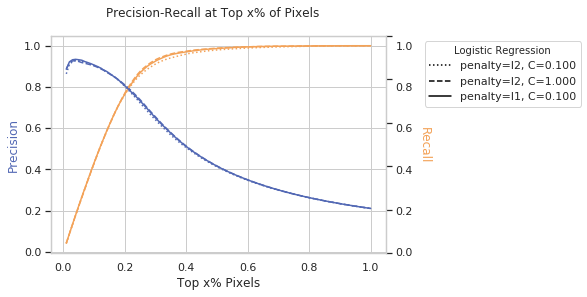

In [9]:
indexes = [2, 3, 6]
legend_title = 'Logistic Regression'

model_utils.plot_precision_recall(
    lr_results['pixel_metrics'], 
    lr_results['labels'], 
    indexes=indexes,
    level='pixel',
    legend_title=legend_title
)

### Settlement-level Performance

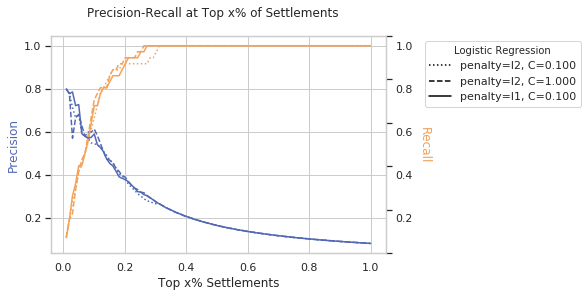

In [10]:
model_utils.plot_precision_recall(
    lr_results['grid_metrics'], 
    lr_results['labels'],
    indexes=indexes,
    level='grid',
    legend_title=legend_title
)

### Pixel-level Performance per Municipality

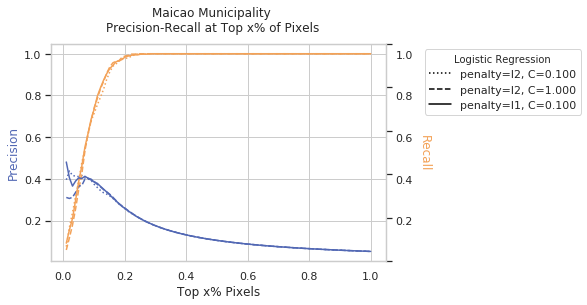

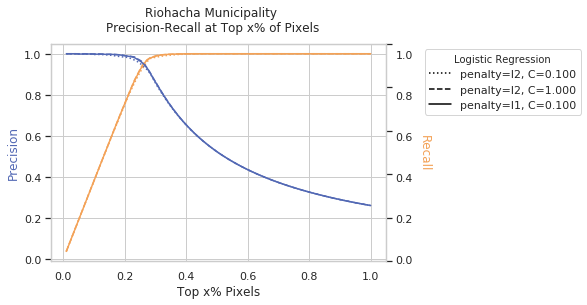

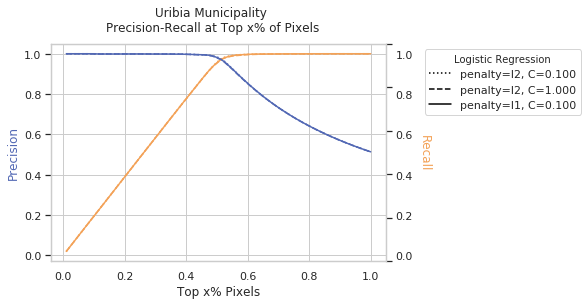

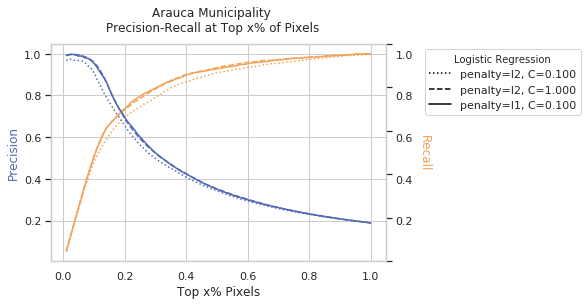

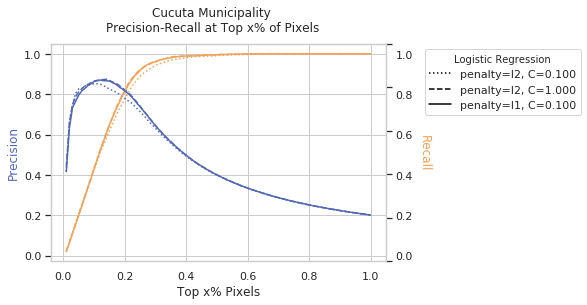

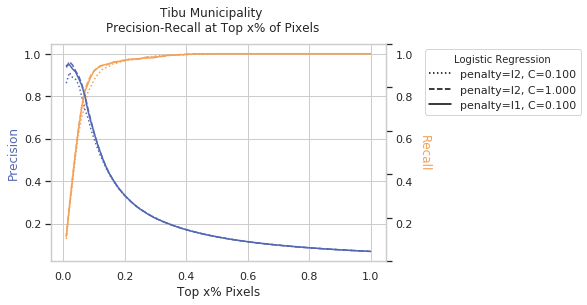

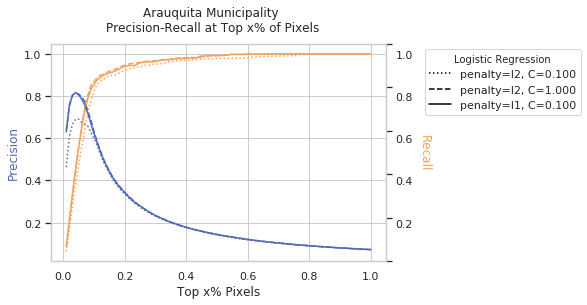

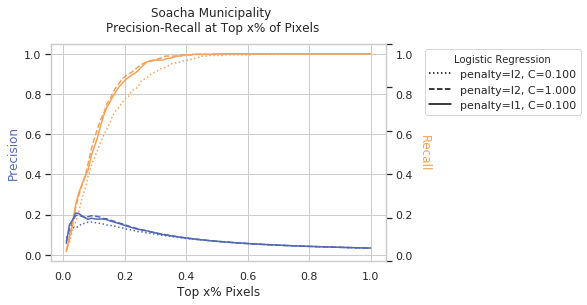

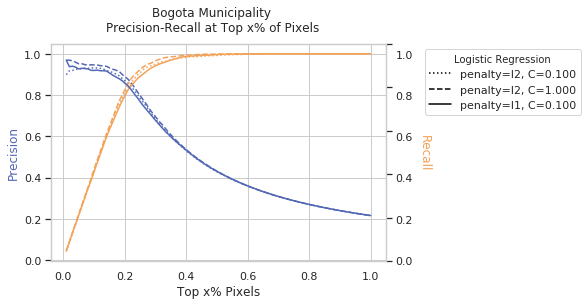

In [16]:
model_utils.plot_precision_recall_per_area(
    lr_results, 
    indexes=indexes, 
    level='pixel', 
    legend_title=legend_title
);

### Settlement-level Performance per Municipality

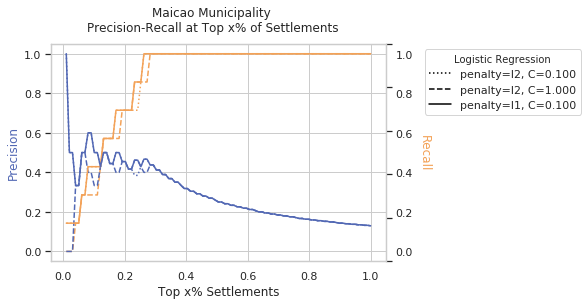

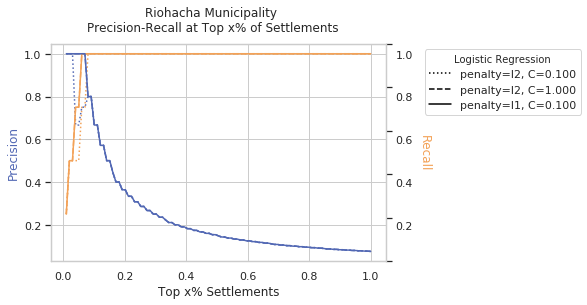

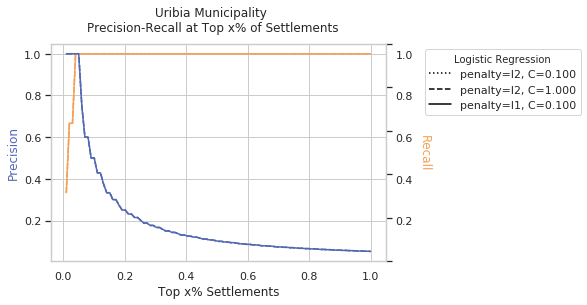

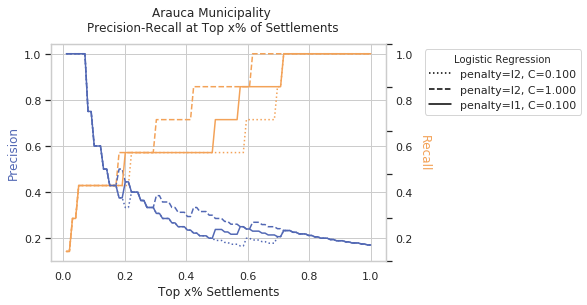

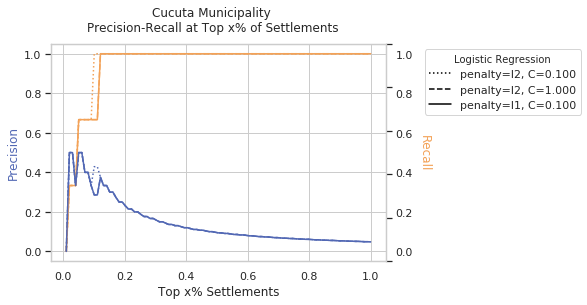

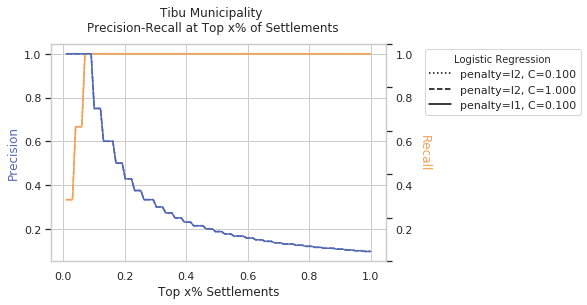

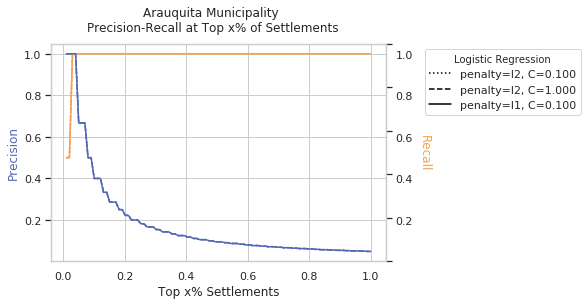

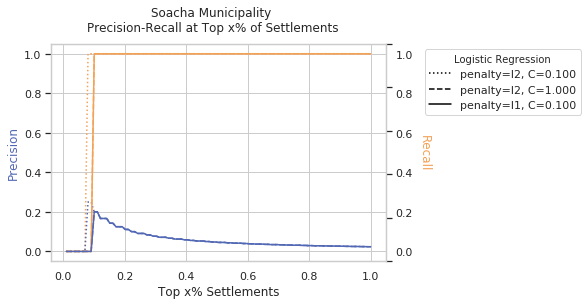

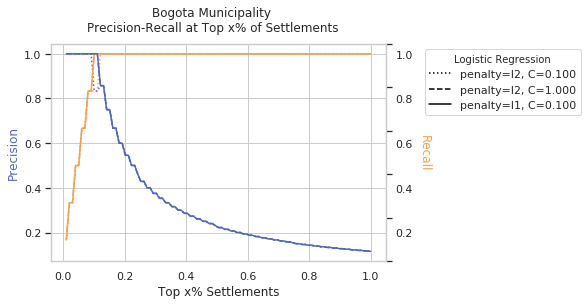

In [17]:
model_utils.plot_precision_recall_per_area(
    lr_results,
    indexes=indexes, 
    level='grid',
    legend_title=legend_title
);

## Random Forest Classifier

### Define Hyperparameters

In [18]:
models, labels = model_utils.get_hyperparameters(model='random_forest')

### Spatial Cross Validation

In [ ]:
rf_results = model_utils.evaluate_model(models, labels, X, y, splits, grids, verbose=2);

### Save Results

In [ ]:
model_utils.save_results(rf_results, results_dir, model_prefix='random_forest')

### Load Results

In [19]:
rf_results = model_utils.load_results(labels, results_dir, model_prefix='random_forest')

### Pixel-level Performance

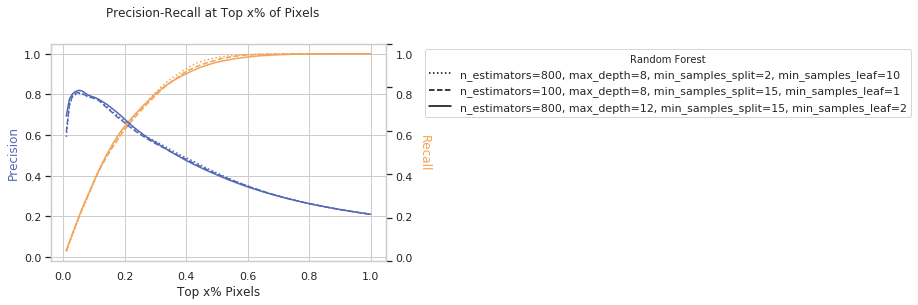

In [20]:
indexes = [0, 1, 3]
legend_title = 'Random Forest'

model_utils.plot_precision_recall(
    rf_results['pixel_metrics'], 
    indexes=indexes, 
    labels=rf_results['labels'], 
    level='pixel', 
    legend_title=legend_title
)

### Settlement-level Performance

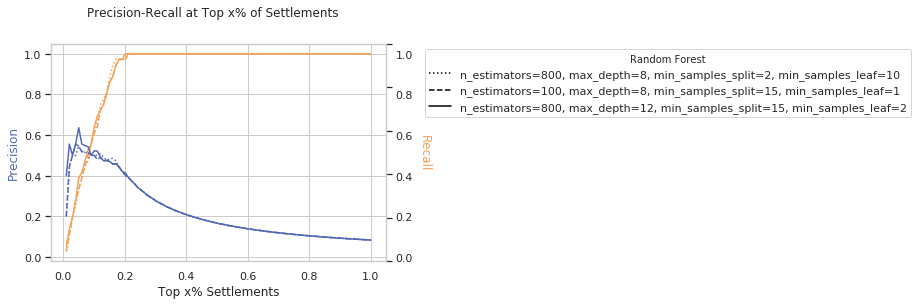

In [21]:
model_utils.plot_precision_recall(
    rf_results['grid_metrics'], 
    indexes=indexes, 
    labels=rf_results['labels'], 
    level='grid',
    legend_title=legend_title
)

### Pixel-level Performance per Municipality

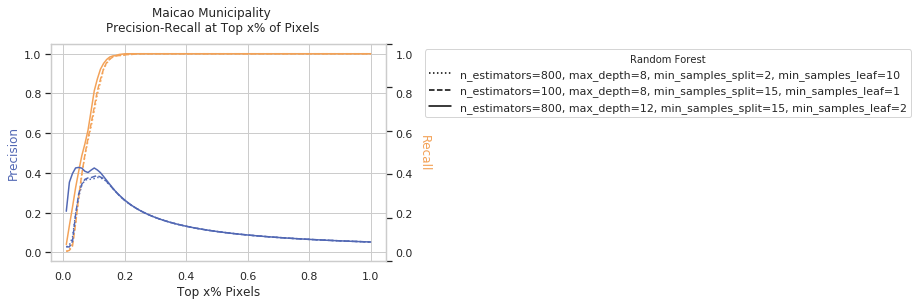

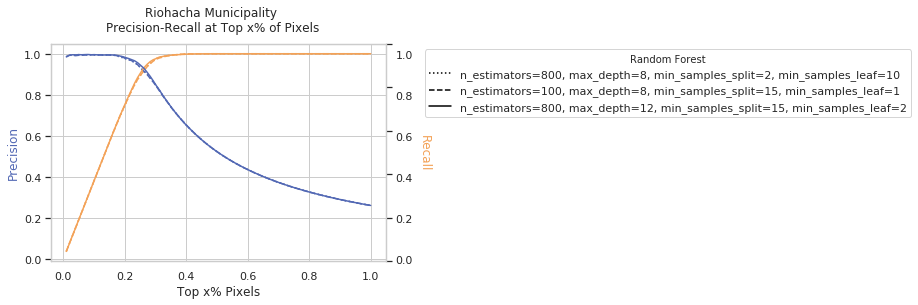

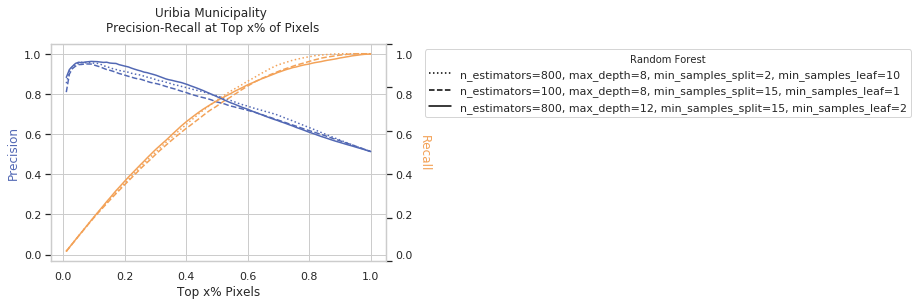

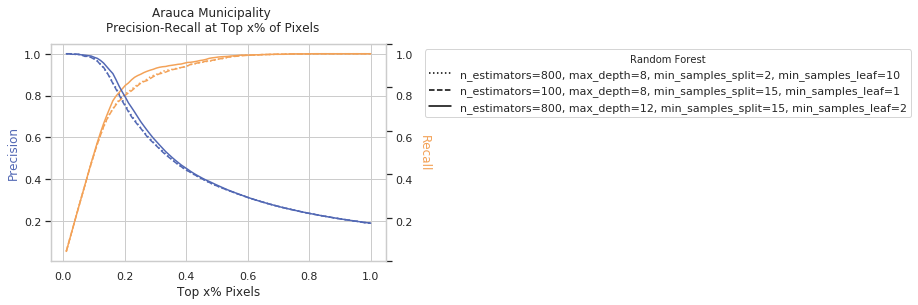

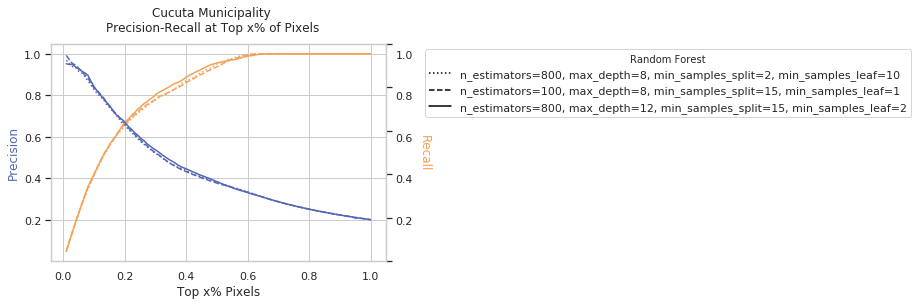

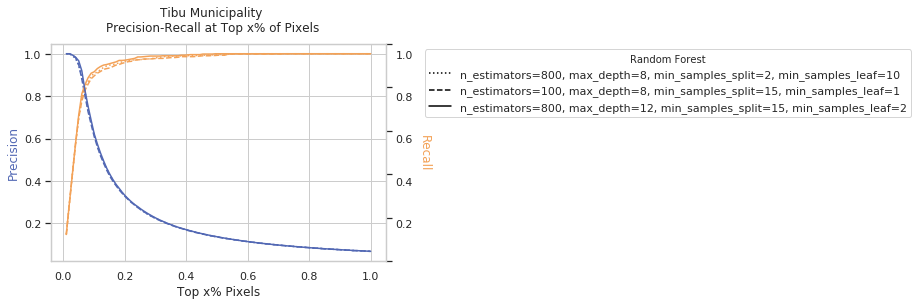

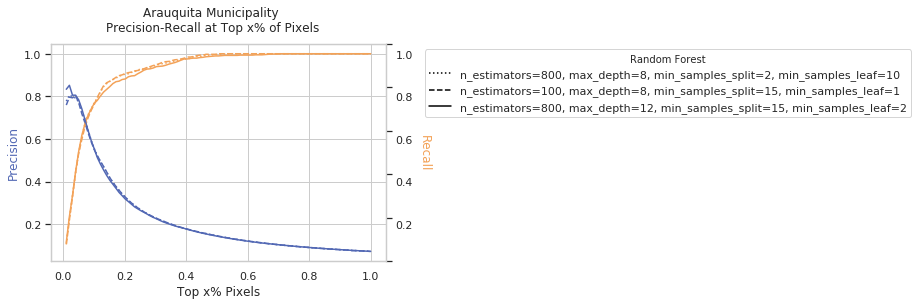

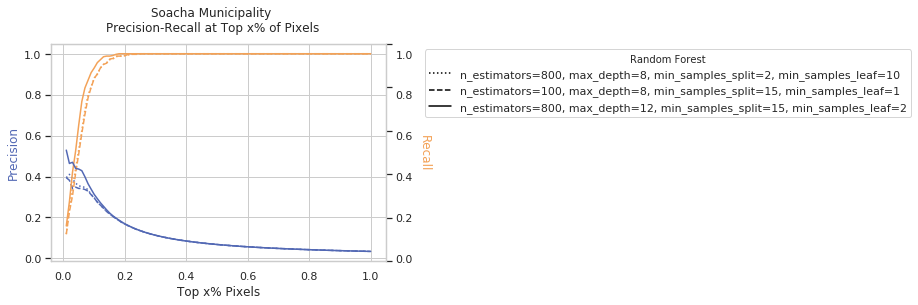

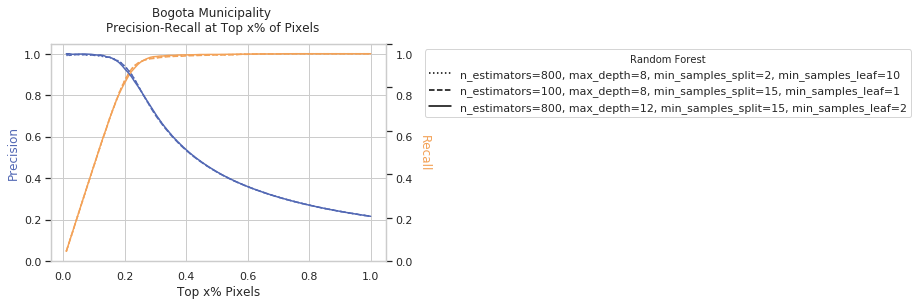

In [22]:
model_utils.plot_precision_recall_per_area(
    rf_results,
    indexes=indexes, 
    level='pixel', 
    legend_title=legend_title
);

### Settlement-level Performance per Municipality

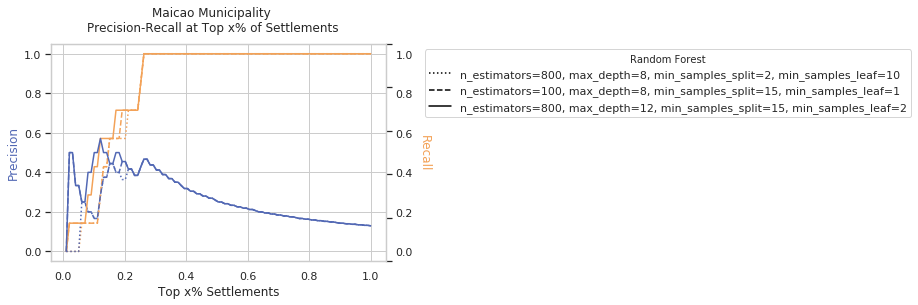

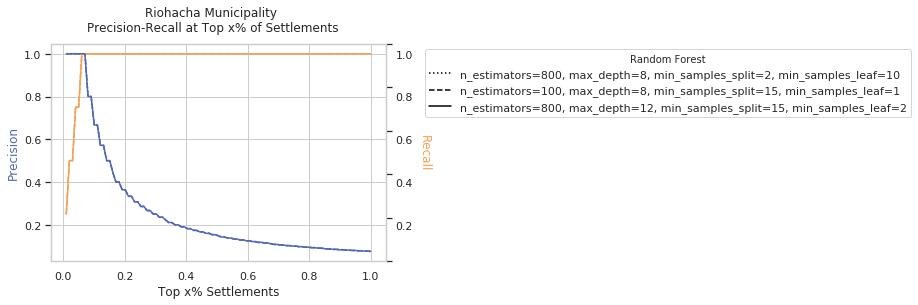

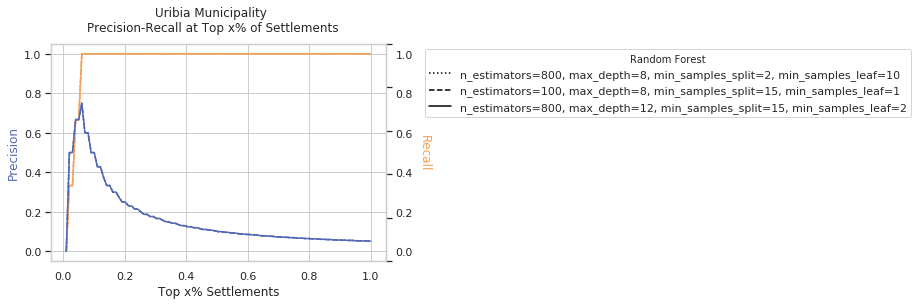

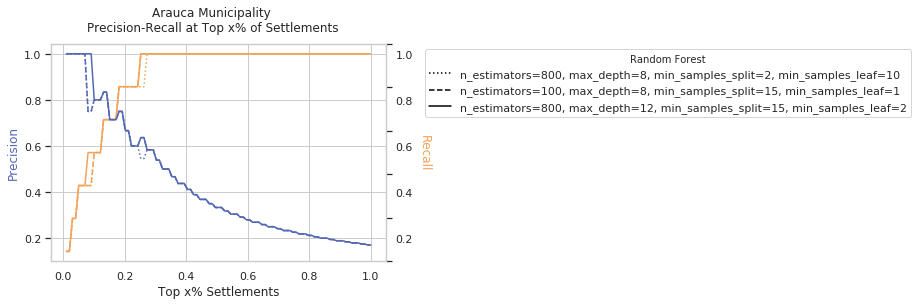

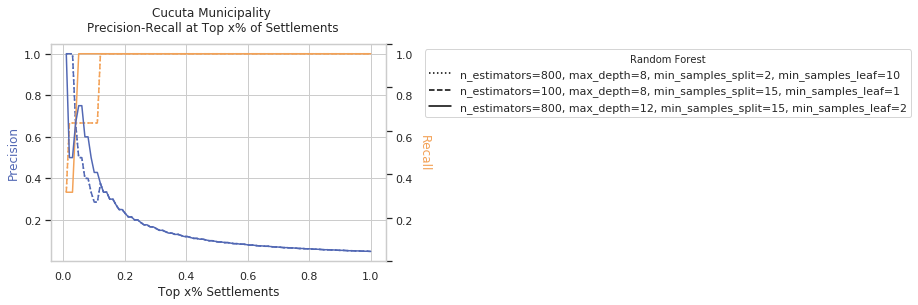

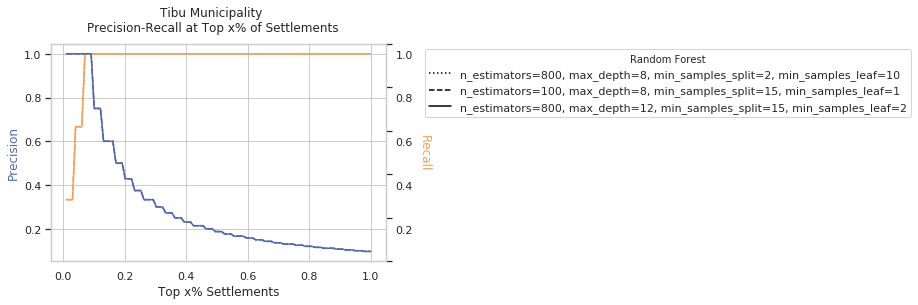

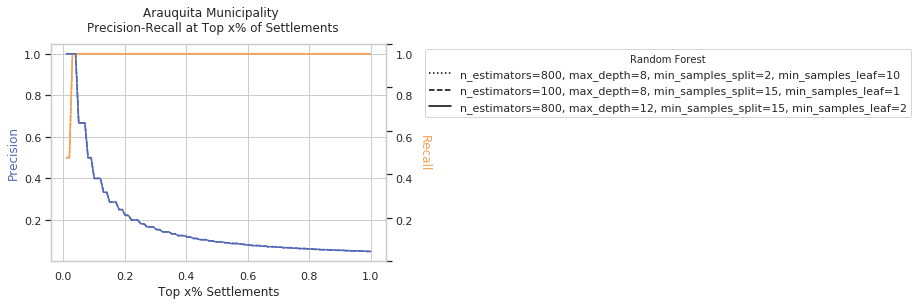

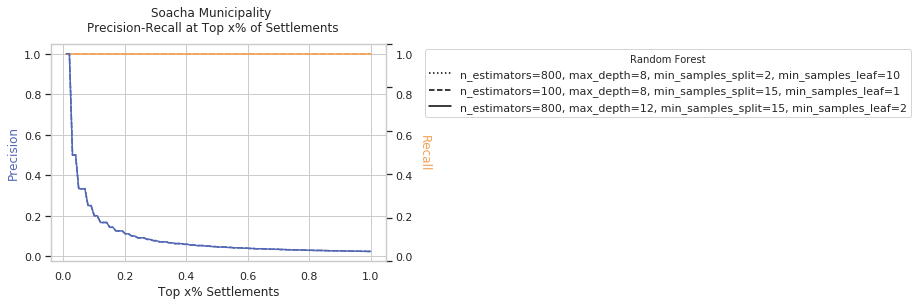

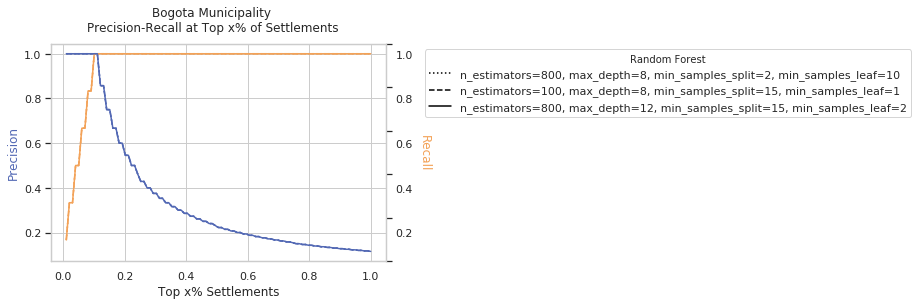

In [23]:
model_utils.plot_precision_recall_per_area(
    rf_results, 
    indexes=indexes, 
    level='grid',
    legend_title=legend_title
);

## Support Vector Machines

### Define Hyperparameters

In [24]:
models, labels = model_utils.get_hyperparameters(model='linear_svc')

### Spatial Cross Validation

In [27]:
svc_results = model_utils.evaluate_model(models, labels, X, y, splits, grids, verbose=2)

Parameters: C=0.001 | Processing Bogota: 100%|██████████| 9/9 [00:16<00:00,  1.87s/it]   
Parameters: C=0.010 | Processing Bogota: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]   
Parameters: C=0.100 | Processing Bogota: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]   
Parameters: C=1.000 | Processing Bogota: 100%|██████████| 9/9 [02:07<00:00, 14.13s/it]   


### Save Results

In [ ]:
model_utils.save_results(svc_results, results_dir, model_prefix='linear_svc')

### Load Results

In [26]:
svc_results = model_utils.load_results(labels, results_dir, model_prefix='linear_svc');

### Pixel-level Performance

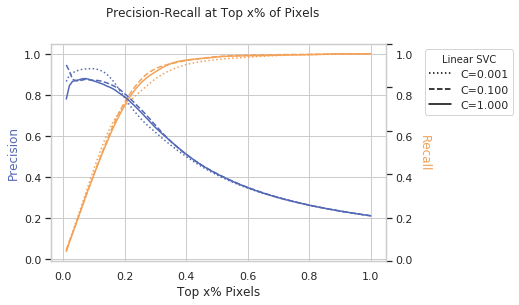

In [32]:
indexes = [0, 2, 3]
legend_title = 'Linear SVC'

model_utils.plot_precision_recall(
    svc_results['pixel_metrics'], 
    indexes=indexes,
    labels=svc_results['labels'], 
    level='pixel',
    legend_title=legend_title
)

### Settlement-level Performance

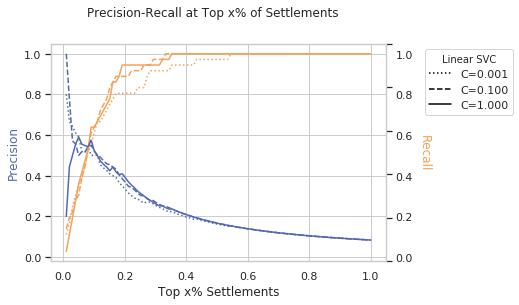

In [33]:
model_utils.plot_precision_recall(
    svc_results['grid_metrics'], 
    indexes=indexes,
    labels=svc_results['labels'], 
    level='grid',
    legend_title=legend_title
)

### Pixel-level Performance per Municipality

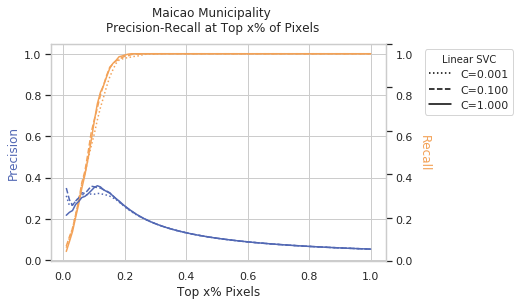

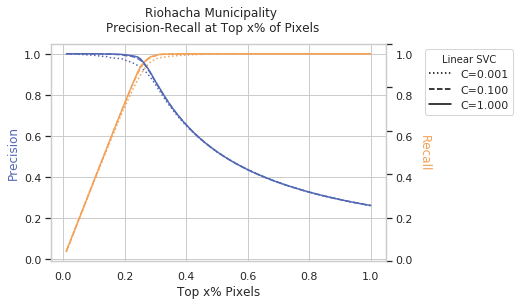

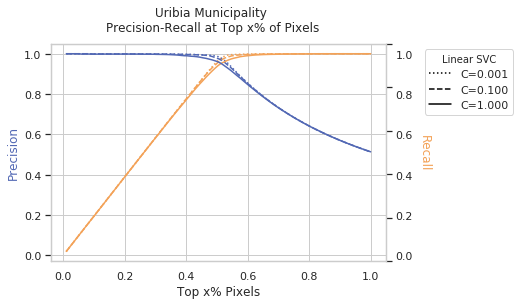

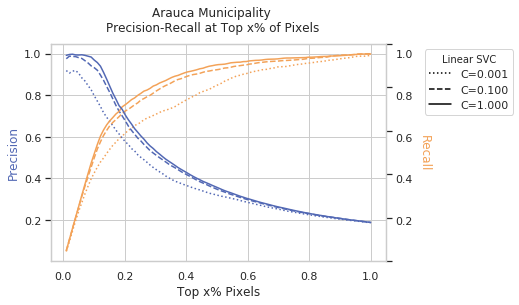

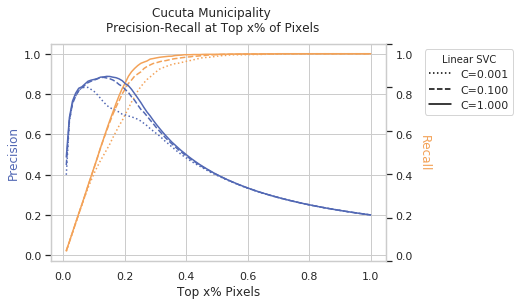

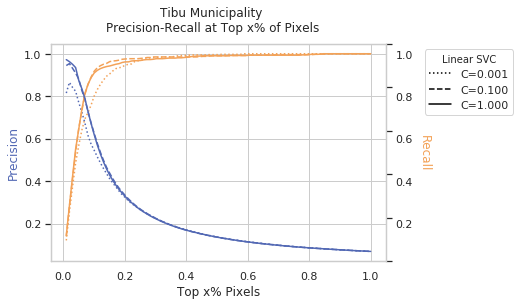

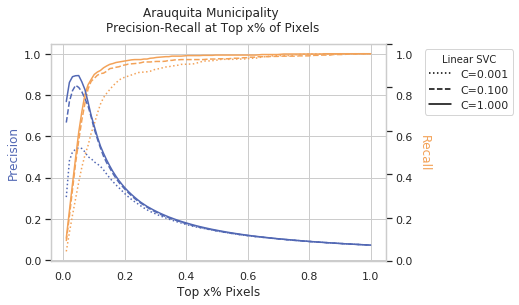

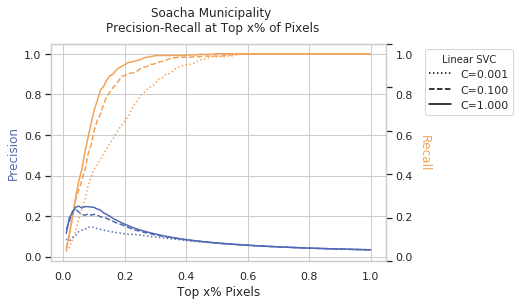

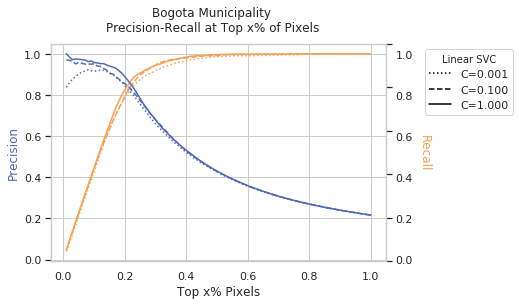

In [34]:
model_utils.plot_precision_recall_per_area(
    svc_results,
    indexes=indexes, 
    level='pixel', 
    legend_title=legend_title
);

### Settlement-level Performance per Municipality

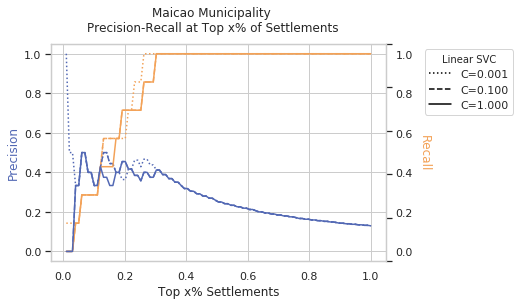

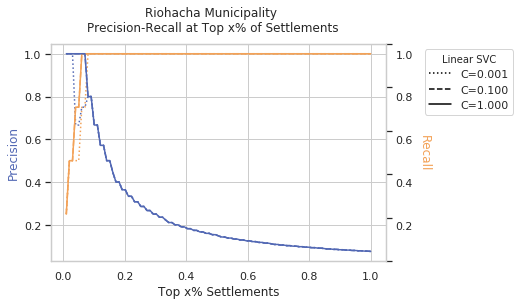

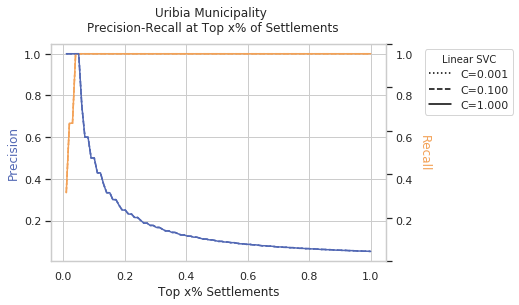

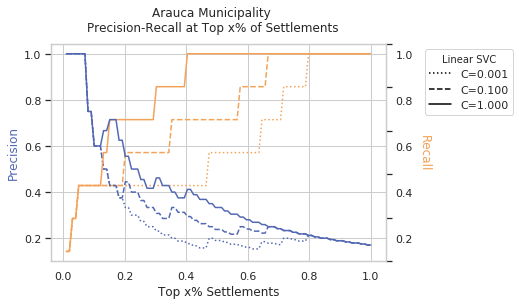

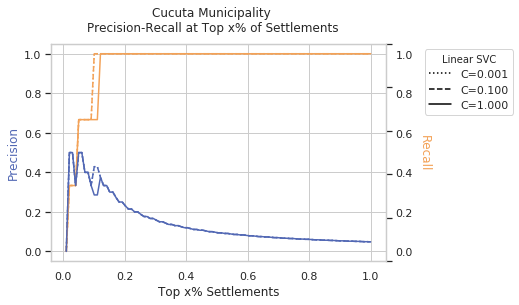

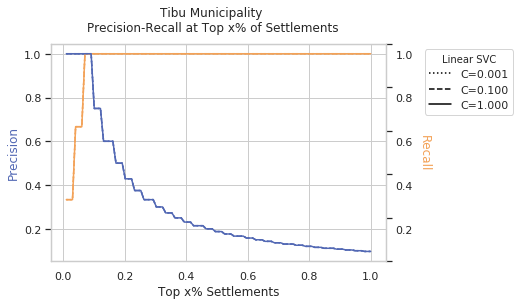

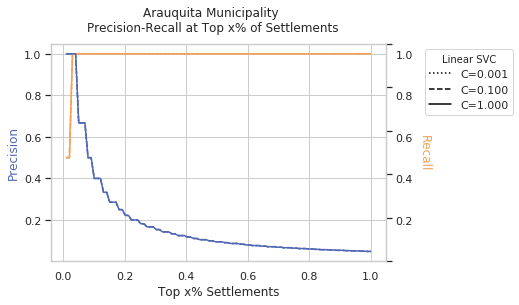

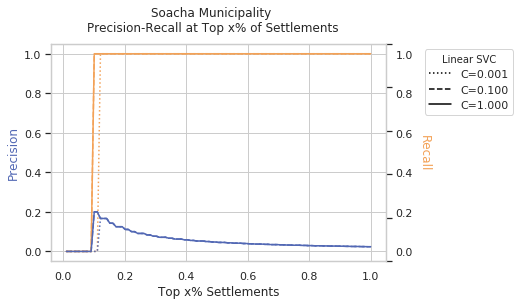

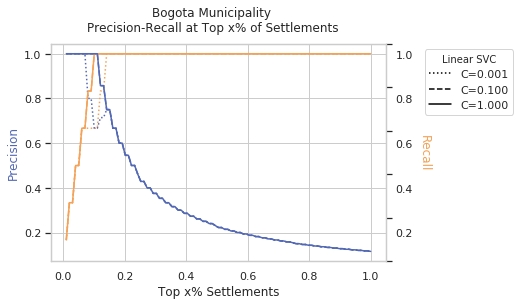

In [35]:
model_utils.plot_precision_recall_per_area(
    svc_results, 
    indexes=indexes, 
    level='grid',
    legend_title=legend_title
);

## Best Models

In [41]:
results = {
    'labels' : ['Linear SVC', 'Logistic Regression', 'Random Forest'],
    'pixel_preds' : [
        svc_results['pixel_preds'][3], 
        lr_results['pixel_preds'][6],
        rf_results['pixel_preds'][3], 
    ],
    'pixel_metrics' : [
        svc_results['pixel_metrics'][3], 
        lr_results['pixel_metrics'][6],
        rf_results['pixel_metrics'][3], 
    ],
    'grid_metrics' : [
        svc_results['grid_metrics'][3],
        lr_results['grid_metrics'][6],
        rf_results['grid_metrics'][3],
    ]
}

### Pixel-level Performance 

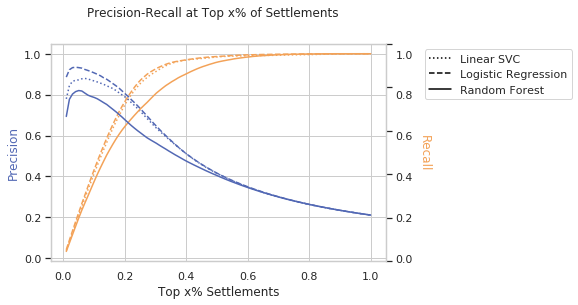

In [42]:
model_utils.plot_precision_recall(results['pixel_metrics'], labels=results['labels'])

### Settlement-level Performance

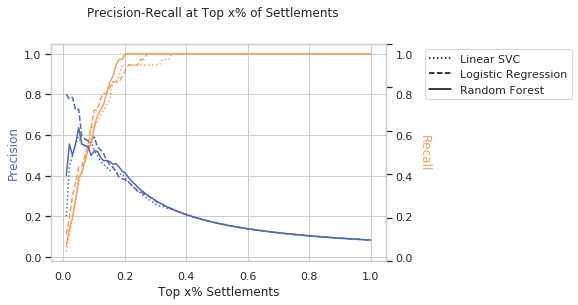

In [43]:
model_utils.plot_precision_recall(results['grid_metrics'], labels=results['labels'])

### Pixel-level Performance per Municipality

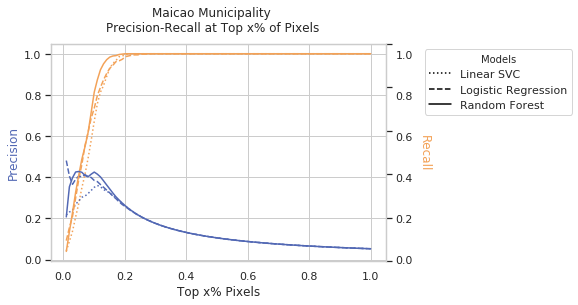

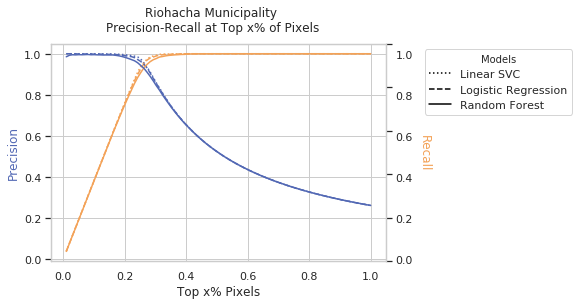

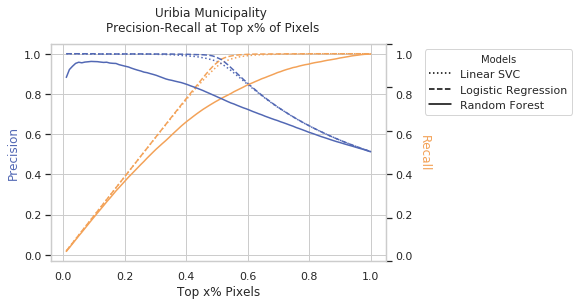

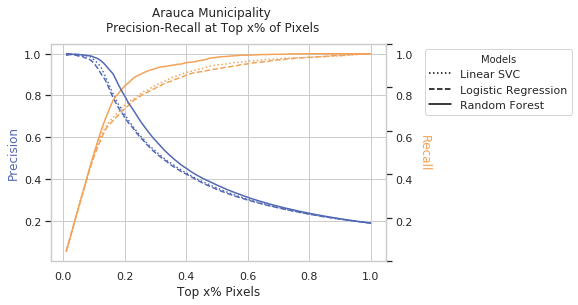

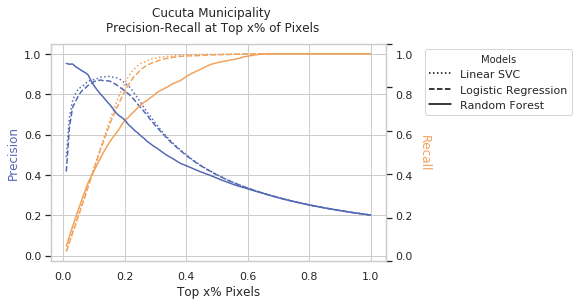

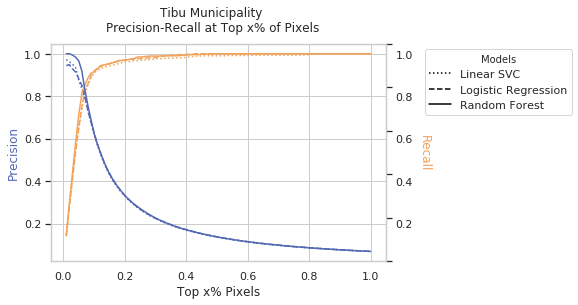

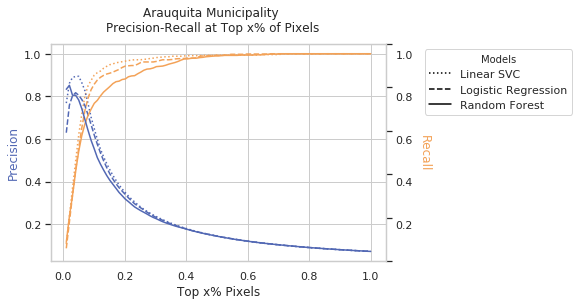

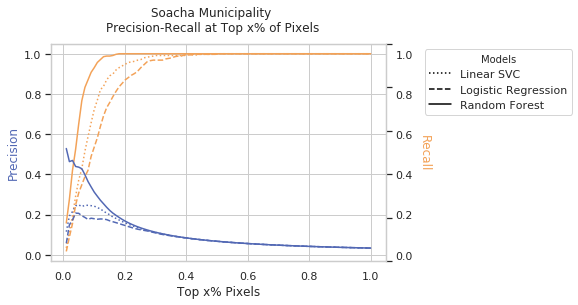

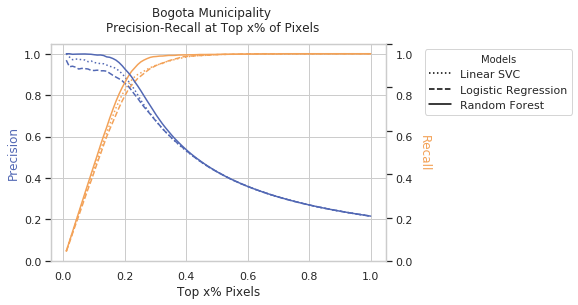

In [44]:
model_utils.plot_precision_recall_per_area(
    results, level='pixel', legend_title='Models'
);

### Settlement-level Performance per Municipality

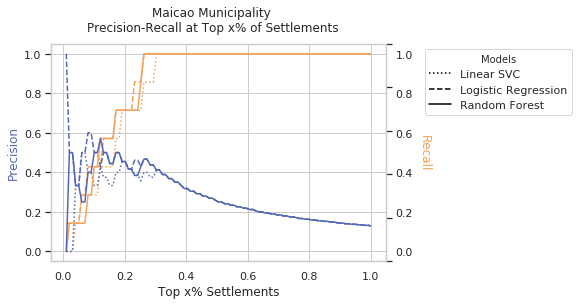

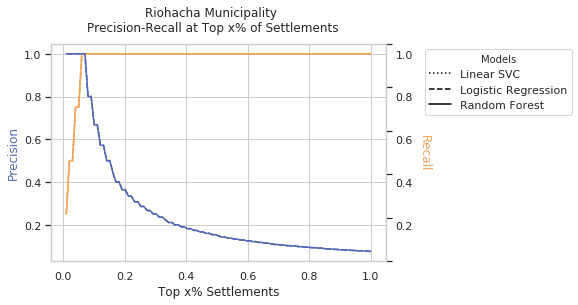

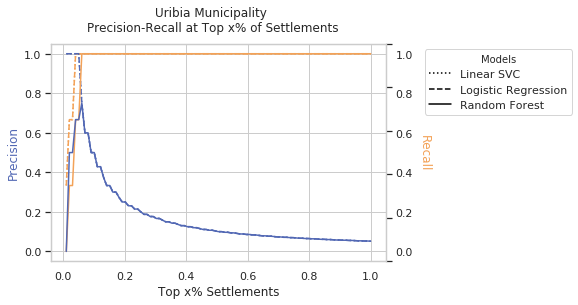

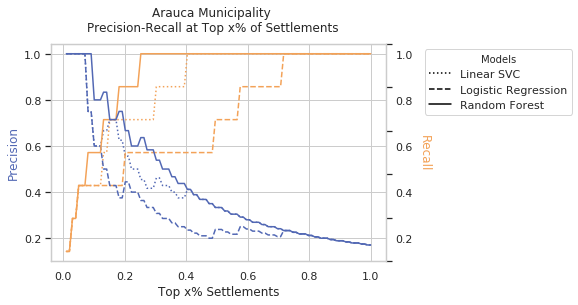

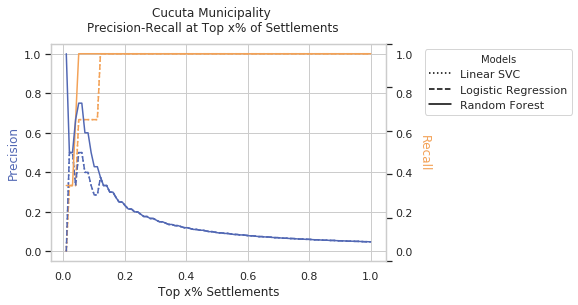

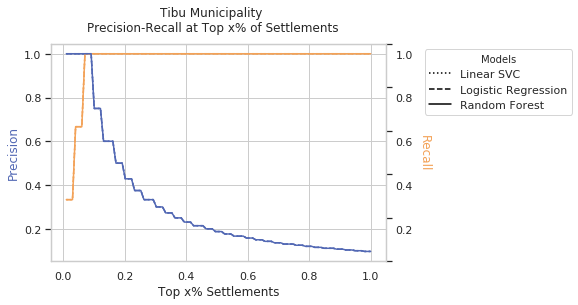

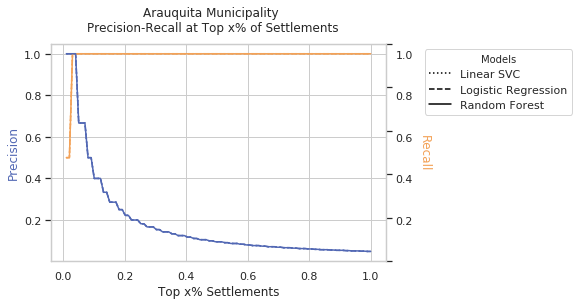

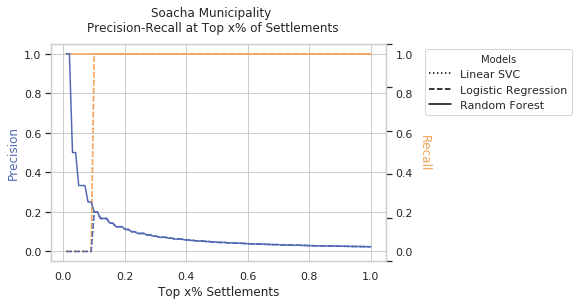

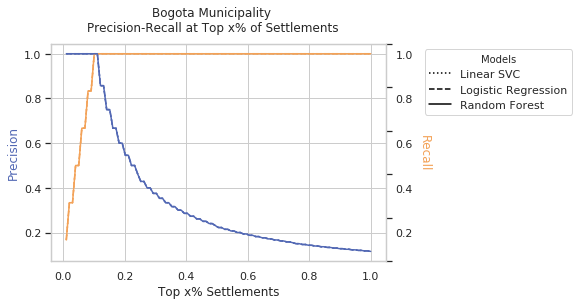

In [45]:
model_utils.plot_precision_recall_per_area(
    results, level='grid', legend_title='Models'
);

## Best Model Score Distributions

### Logistic Regression: Pixel-level Predictions

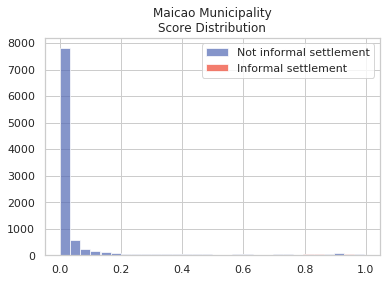

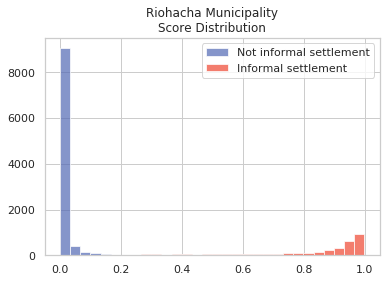

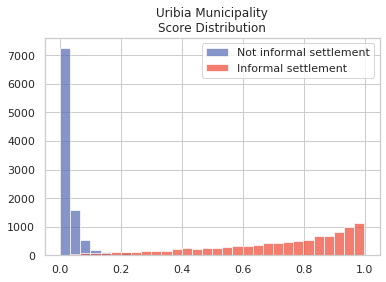

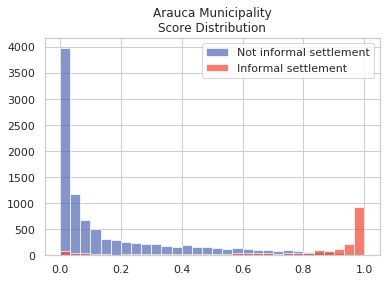

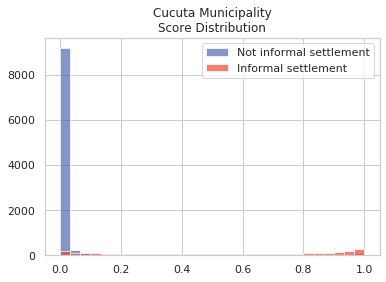

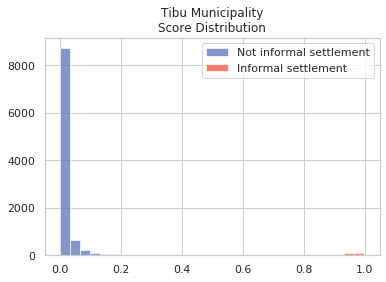

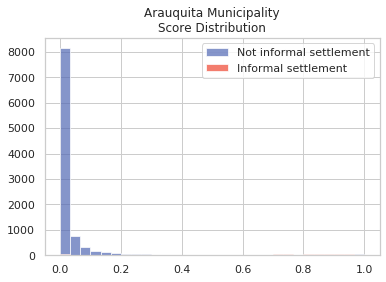

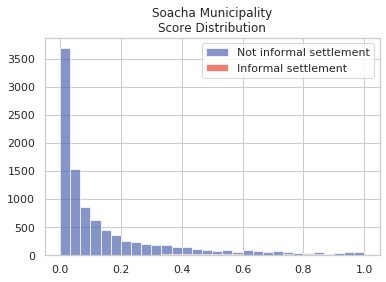

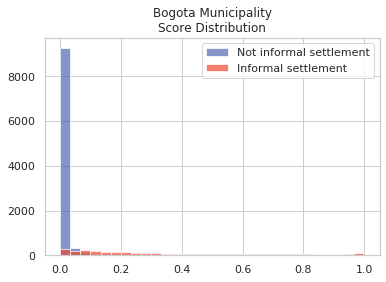

In [135]:
model_utils.calculate_score_distribution(lr_results['pixel_preds'][6])

### Random Forest: Pixel-level Predictions

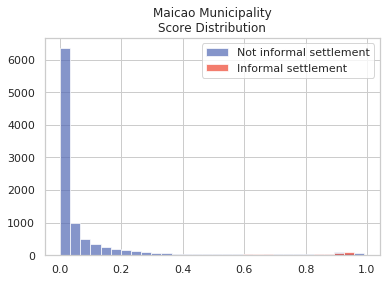

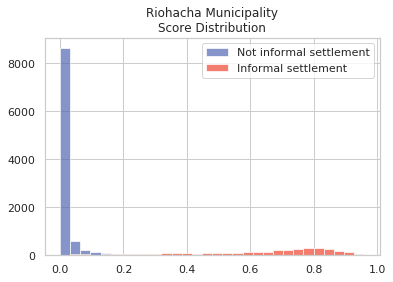

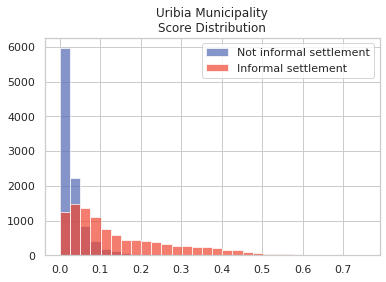

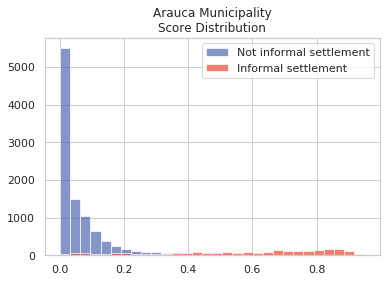

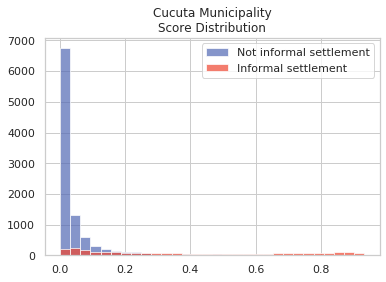

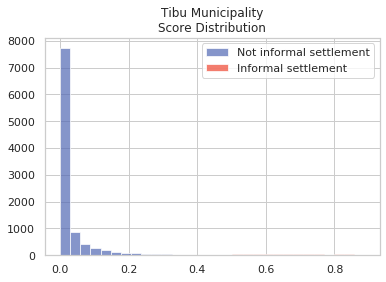

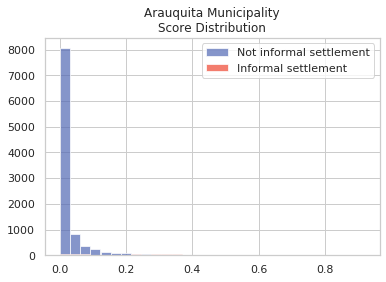

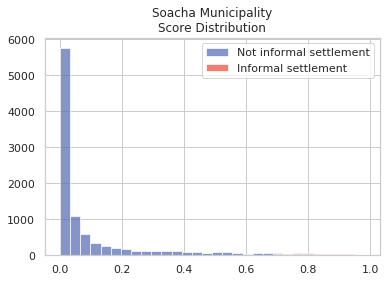

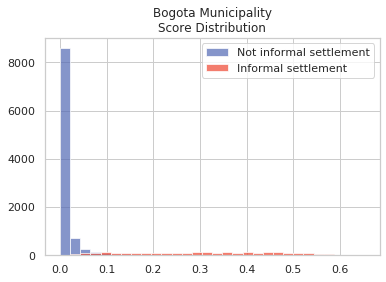

In [136]:
model_utils.calculate_score_distribution(rf_results['pixel_preds'][3])

### Logistic Regression: Settlement-level Predictions

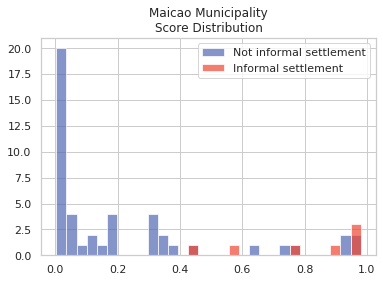

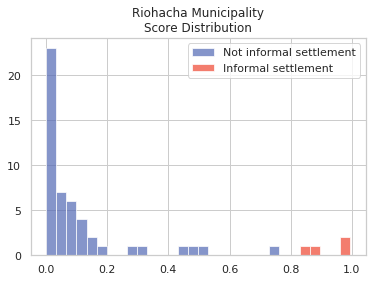

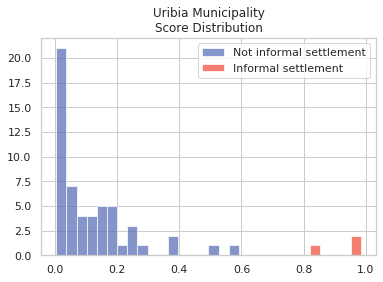

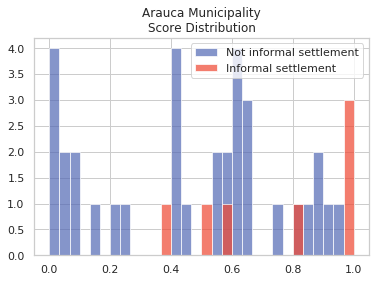

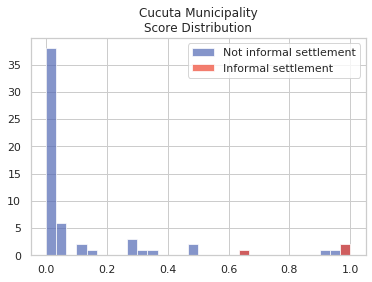

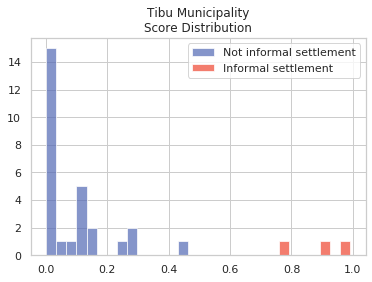

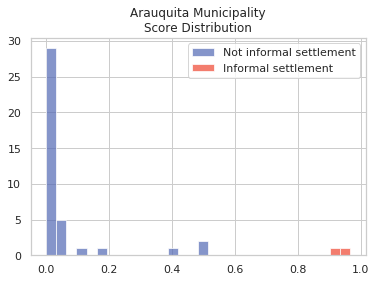

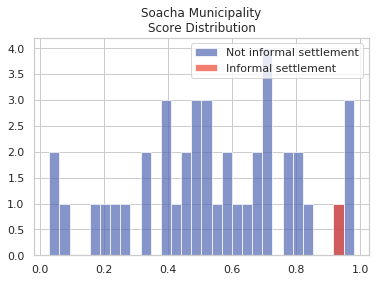

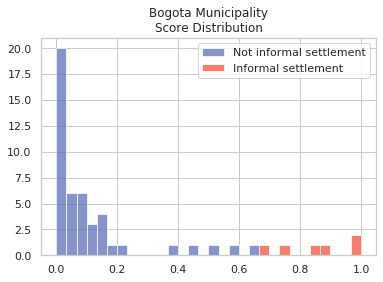

In [137]:
model_utils.calculate_score_distribution(lr_results['grid_preds'][6])

### Random Forest: Settlement-level Predictions

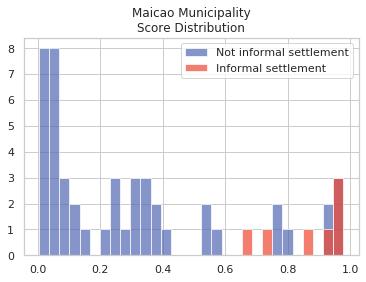

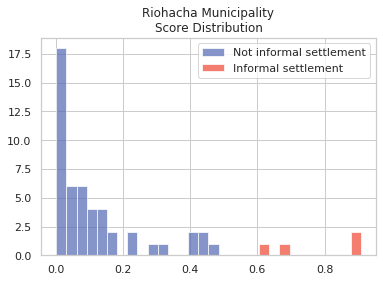

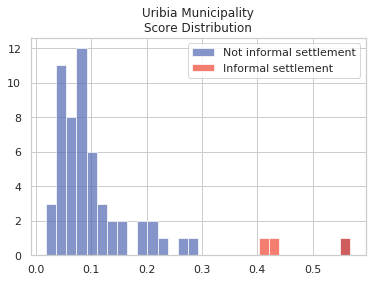

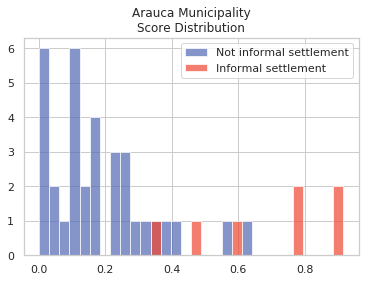

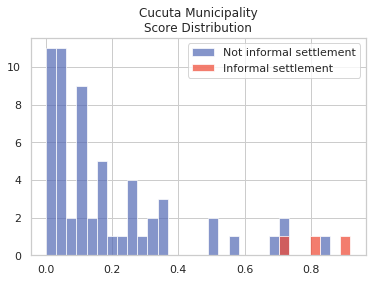

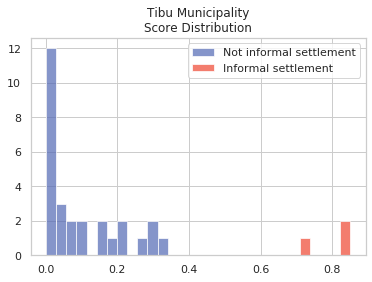

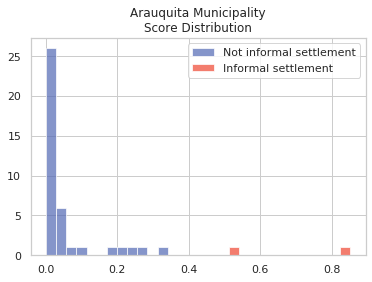

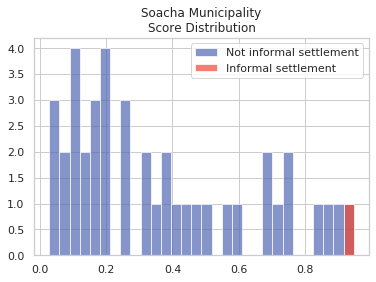

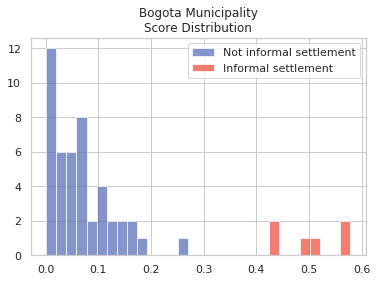

In [138]:
model_utils.calculate_score_distribution(rf_results['grid_preds'][3])